# Project 4 - Notebook 3 - Modelling Q2 (by Wilson Alberto Torres)

In [9]:
!pip install eli5
!pip install xgboost

In [11]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from IPython.display import display
#from xgboost import XGBClassifier
import numpy as np
#!pip install eli5
#!pip install xgboost
import eli5
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from gensim import corpora, models, matutils
from collections import defaultdict
from nltk.corpus import stopwords

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


# Importing the cleaned dataset

In [12]:
# importing cleaned dataset, ready for modelling
result_df3 = pd.read_csv('jobs_project4-modelQ2.csv')

In [13]:
result_df3.head(2)

,job_id,s_keyword,job_title,city,job_type,job_field,job_subfield,range_sal,job_full_desc
0,50354487,data-analyst,Excel Data Analyst,Melbourne,This is a Contract/Temp job,Information & Communication Technology,Other,30000-60000,Our Client has a new opportunity for a Excel D...
1,50392356,data-analyst,Product Analytics Specialist,Melbourne,This is a Full Time job,Information & Communication Technology,Product Management & Development,30000-60000,Product Analytics Specialist Openpay ASX: OPY ...


In [14]:
result_df3.groupby(['s_keyword'])[['job_id']].count()

,job_id
s_keyword,
data-analyst,4922
data-engineer,588
data-science,388


In [15]:
result_df3.nunique()

job_id           5898
s_keyword           3
job_title        4455
city                2
job_type            4
job_field          29
job_subfield      258
range_sal           3
job_full_desc    5520
dtype: int64

In [16]:
result_df3.groupby(['job_field'])['job_id'].count().sort_values(ascending=False)

job_field
Information & Communication Technology    2180
Marketing & Communications                 496
Banking & Financial Services               449
Accounting                                 447
Healthcare & Medical                       246
Sales                                      228
Manufacturing, Transport & Logistics       211
Government & Defence                       187
Administration & Office Support            161
Engineering                                147
Science & Technology                       119
Human Resources & Recruitment              115
Education & Training                       110
Consulting & Strategy                      108
Insurance & Superannuation                 106
Construction                                88
Community Services & Development            83
Call Centre & Customer Service              70
Retail & Consumer Products                  60
Real Estate & Property                      59
Trades & Services                           59
Des

In [17]:
result_df3[result_df3['job_title'].str.contains('Sci')].count()

job_id           79
s_keyword        79
job_title        79
city             79
job_type         79
job_field        79
job_subfield     79
range_sal        79
job_full_desc    79
dtype: int64

# Defining the predictor and the target variable

In [18]:
X_pre = result_df3['job_full_desc'].values # predictor
X_pre = X_pre.reshape(-1, 1)
X_pre.shape

(5898, 1)

In [19]:
y_pre = result_df3['s_keyword'].map(lambda x: 1 if x in ['data-science'] else 0)
y_pre.values
y_pre.shape

(5898,)

In [20]:
X_pre.shape, y_pre.shape

((5898, 1), (5898,))

In [21]:
pd.Series(y_pre).value_counts(normalize=True) # baseline

0    0.934215
1    0.065785
Name: s_keyword, dtype: float64

<AxesSubplot:xlabel='s_keyword', ylabel='count'>

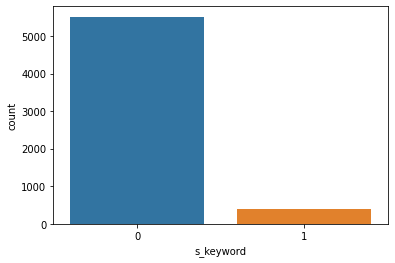

In [22]:
# This shows that this target variable is imbalance so we need to transform it before running the models
sns.countplot(y_pre)

In [23]:
#!pip install imblearn

In [24]:
from imblearn.over_sampling import RandomOverSampler
os = RandomOverSampler(random_state=42)

In [25]:
# Over sampling to handle the imbalance variable
X, y_class = os.fit_resample(X_pre, y_pre)
print(X.shape,y_class.shape)

(11020, 1) (11020,)


<AxesSubplot:xlabel='s_keyword', ylabel='count'>

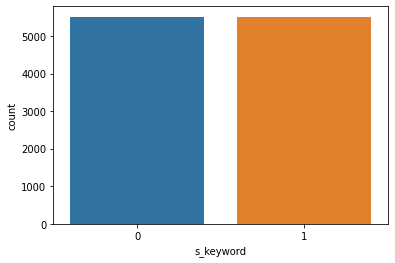

In [26]:
# The target variable is now balance:
sns.countplot(y_class)

In [27]:
pd.Series(y_class).value_counts(normalize=True) # baseline

1    0.5
0    0.5
Name: s_keyword, dtype: float64

In [181]:
# Transforming the predictor to a Series
X = pd.DataFrame(X)
X = X[0]
X.shape

(11020,)

In [193]:
custom_stop_words = list(ENGLISH_STOP_WORDS)
X_train, X_test, y_train, y_test = train_test_split(X,y_class,random_state=42, stratify=y_class)
X_test.shape

(2755,)

In [200]:
def model_evaluation(pipeline_in):
    scores = cross_val_score(pipeline_in, X, y_class)
    print(f'Mean cross-val score: {scores.mean()}')
    print(f'Standard deviation cross-val:{scores.std()}')
    
    pipeline_in.fit(X_train,y_train) # training the model
    pipeline_in.score(X_test,y_test) 
    y_hat_this = pipeline_in.predict(X_test)
    y_hat_pr_this = pipeline_in.predict_proba(X_test)
    print('----------------------------------------')
    print('Classification Report')
    print('----------------------------------------')
    print(classification_report(y_test,y_hat_this))
    
    print('----------------------------------------')
    print('Confusion Matrix')
    print('----------------------------------------')
    conmat = np.array(confusion_matrix(y_test,y_hat_this,labels=[1,0]))
    confusion = pd.DataFrame(conmat, index=['is_high_salary', 'is_low_salary'],
                         columns=['predicted_high_salary','predicted_low_salary'])
    print(confusion)
    
    fpr, tpr, th = roc_curve(y_test, y_hat_pr_this[:,1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=[5,5])
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver operating characteristic', fontsize=12)
    plt.legend(loc="lower right")
    plt.show()
    
    display(eli5.explain_weights(pipeline_in))

# Experiment 1: Logistic Regression with full-job-description feature

In [184]:
# Creating the pipeline
pl_e1 = make_pipeline(CountVectorizer(stop_words=custom_stop_words, binary=True), LogisticRegression())

/opt/anaconda3/envs/gres/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/gres/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Mean cross-val score: 0.9668784029038113
Standard deviation cross-val:0.0036410894097529596


/opt/anaconda3/envs/gres/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


----------------------------------------
Classification Report
----------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1378
           1       0.96      1.00      0.98      1377

    accuracy                           0.98      2755
   macro avg       0.98      0.98      0.98      2755
weighted avg       0.98      0.98      0.98      2755

----------------------------------------
Confusion Matrix
----------------------------------------
                predicted_high_salary  predicted_low_salary
is_high_salary                   1377                     0
is_low_salary                      53                  1325


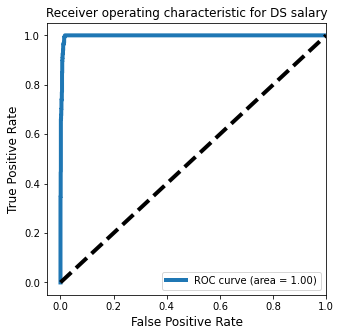

Weight?,Feature
+3.328,science
+1.395,september
+1.366,sciences
+1.150,data
+1.054,computer
+0.943,engineers
+0.935,teradata
+0.907,python
+0.814,stable
+0.805,practice


In [185]:
model_evaluation(pl_e1)

# Experiment 2: Random Forest Classifier with job-full-description feature

In [191]:
pl_e3 = make_pipeline(CountVectorizer(stop_words=custom_stop_words, binary=True), 
                                RandomForestClassifier(n_estimators=1000))

Mean cross-val score: 0.9961887477313974
Standard deviation cross-val:0.0013641829744440032
----------------------------------------
Classification Report
----------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1378
           1       1.00      1.00      1.00      1377

    accuracy                           1.00      2755
   macro avg       1.00      1.00      1.00      2755
weighted avg       1.00      1.00      1.00      2755

----------------------------------------
Confusion Matrix
----------------------------------------
                predicted_high_salary  predicted_low_salary
is_high_salary                   1377                     0
is_low_salary                       6                  1372


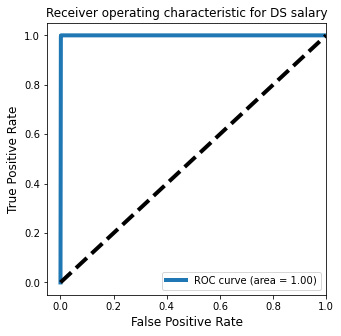

Weight,Feature
0.0357 ± 0.1339,science
0.0098 ± 0.0406,computer
0.0081 ± 0.0307,manager
0.0063 ± 0.0248,python
0.0063 ± 0.0258,data
0.0049 ± 0.0216,degree
0.0040 ± 0.0175,sciences
0.0035 ± 0.0189,september
0.0031 ± 0.0130,engineering
0.0026 ± 0.0109,sql


In [192]:
model_evaluation(pl_e3)

# Experiment 3: Logistic regression - with full job description v2 

In [194]:
# Creating the pipeline
pl_e4 = make_pipeline(CountVectorizer(stop_words=custom_stop_words,
                                         ngram_range = (2,2),
                                         binary=True,
                                        min_df=5,
                                        max_df=0.25), LogisticRegression())

/opt/anaconda3/envs/gres/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/gres/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Mean cross-val score: 0.9912885662431943
Standard deviation cross-val:0.0015821774749693843


/opt/anaconda3/envs/gres/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


----------------------------------------
Classification Report
----------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1378
           1       0.99      1.00      1.00      1377

    accuracy                           1.00      2755
   macro avg       1.00      1.00      1.00      2755
weighted avg       1.00      1.00      1.00      2755

----------------------------------------
Confusion Matrix
----------------------------------------
                predicted_high_salary  predicted_low_salary
is_high_salary                   1377                     0
is_low_salary                      12                  1366


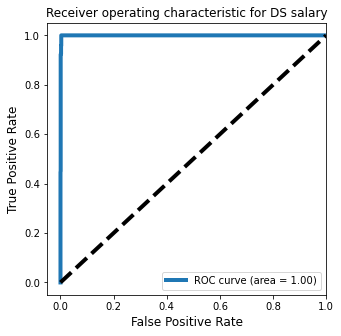

Weight?,Feature
+1.674,computer science
+0.913,science related
+0.821,data engineer
+0.786,head product
+0.737,science engineering
+0.734,cto ksuper
+0.734,ksuper plus
+0.693,management large
+0.608,september baker
+0.588,friday september


In [195]:
model_evaluation(pl_e4)

# Experiment 4: KNN - with full-job-description feature

In [196]:
# Creating the pipeline
pl_e5 = make_pipeline(CountVectorizer(stop_words=custom_stop_words,
                                         ngram_range = (1,2),
                                         binary=True,
                                        min_df=5,
                                        max_df=0.25), KNeighborsClassifier(n_neighbors=5, weights='uniform'))

Mean cross-val score: 0.9907441016333938
Standard deviation cross-val:0.002196682111961911
----------------------------------------
Classification Report
----------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1378
           1       0.98      0.99      0.99      1377

    accuracy                           0.99      2755
   macro avg       0.99      0.99      0.99      2755
weighted avg       0.99      0.99      0.99      2755

----------------------------------------
Confusion Matrix
----------------------------------------
                predicted_high_salary  predicted_low_salary
is_high_salary                   1369                     8
is_low_salary                      29                  1349


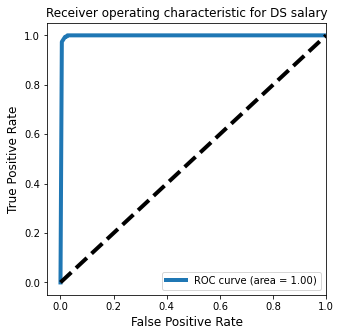

Explanation(estimator="Pipeline(steps=[('countvectorizer',\n                 CountVectorizer(binary=True, max_df=0.25, min_df=5,\n                                 ngram_range=(1, 2),\n                                 stop_words=['ten', 'done', 'into', 'two',\n                                             'will', 'before', 'find', 'only',\n                                             'indeed', 'became', 'ie', 'anyway',\n                                             'upon', 'however', 'would',\n                                             'please', 'never', 'whence',\n                                             'each', 'our', 'perhaps', 'why',\n                                             'bottom', 'which', 'except',\n                                             'since', 'someone', 'con',\n                                             'nevertheless', 'her', ...])),\n                ('kneighborsclassifier', KNeighborsClassifier())])", description=None, error='estimator KNeighborsClassifier() is not supported', method=None, is_regression=False, targets=None, feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [197]:
model_evaluation(pl_e5)

# Experiment 5: SVM - with full-job-description feature

In [198]:
# Creating the pipeline
pl_e6 = make_pipeline(CountVectorizer(stop_words=custom_stop_words,
                                         ngram_range = (1,2),
                                         binary=True,
                                        min_df=5,
                                        max_df=0.25), SVC(probability=True))

Mean cross-val score: 0.9943738656987297
Standard deviation cross-val:0.0014799915091016364
----------------------------------------
Classification Report
----------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1378
           1       0.99      1.00      1.00      1377

    accuracy                           1.00      2755
   macro avg       1.00      1.00      1.00      2755
weighted avg       1.00      1.00      1.00      2755

----------------------------------------
Confusion Matrix
----------------------------------------
                predicted_high_salary  predicted_low_salary
is_high_salary                   1372                     5
is_low_salary                       8                  1370


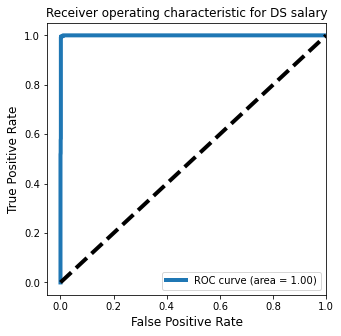

Explanation(estimator="Pipeline(steps=[('countvectorizer',\n                 CountVectorizer(binary=True, max_df=0.25, min_df=5,\n                                 ngram_range=(1, 2),\n                                 stop_words=['ten', 'done', 'into', 'two',\n                                             'will', 'before', 'find', 'only',\n                                             'indeed', 'became', 'ie', 'anyway',\n                                             'upon', 'however', 'would',\n                                             'please', 'never', 'whence',\n                                             'each', 'our', 'perhaps', 'why',\n                                             'bottom', 'which', 'except',\n                                             'since', 'someone', 'con',\n                                             'nevertheless', 'her', ...])),\n                ('svc', SVC(probability=True))])", description=None, error="only kernel='linear' is currently supported for libsvm-based classifiers", method=None, is_regression=False, targets=None, feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [199]:
model_evaluation(pl_e6)

# Experiment 6: Ensemble - AdaBoostClassifier

In [201]:
# Creating the pipeline
pl_e7 = make_pipeline(CountVectorizer(stop_words=custom_stop_words,
                                         ngram_range = (1,2),
                                         binary=True,
                                        min_df=5,
                                        max_df=0.25), 
                         AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                            n_estimators=100))

Mean cross-val score: 0.8982758620689655
Standard deviation cross-val:0.009313545969742447
----------------------------------------
Classification Report
----------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      1378
           1       0.91      0.93      0.92      1377

    accuracy                           0.92      2755
   macro avg       0.92      0.92      0.92      2755
weighted avg       0.92      0.92      0.92      2755

----------------------------------------
Confusion Matrix
----------------------------------------
                predicted_high_salary  predicted_low_salary
is_high_salary                   1278                    99
is_low_salary                     131                  1247


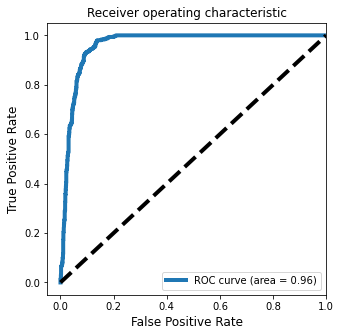

Weight,Feature
0.0200 ± 0.2800,science related
0.0200 ± 0.2800,engineering science
0.0100 ± 0.1990,systems computer
0.0100 ± 0.1990,successful candidate
0.0100 ± 0.1990,month fixed
0.0100 ± 0.1990,oversight
0.0100 ± 0.1990,sales
0.0100 ± 0.1990,science information
0.0100 ± 0.1990,mapping
0.0100 ± 0.1990,way


In [202]:
model_evaluation(pl_e7)

# Experiment 7: Ensemble - XGBoost 

In [112]:
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier

In [203]:
# Creating the pipeline
pl_e8 = make_pipeline(CountVectorizer(stop_words=custom_stop_words,
                                         ngram_range = (1,2),
                                         binary=True,
                                        min_df=5,
                                        max_df=0.25),XGBClassifier())

Mean cross-val score: 0.9737749546279494
Standard deviation cross-val:0.0038112522686025423
----------------------------------------
Classification Report
----------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1378
           1       0.97      1.00      0.99      1377

    accuracy                           0.99      2755
   macro avg       0.99      0.99      0.99      2755
weighted avg       0.99      0.99      0.99      2755

----------------------------------------
Confusion Matrix
----------------------------------------
                predicted_high_salary  predicted_low_salary
is_high_salary                   1377                     0
is_low_salary                      38                  1340


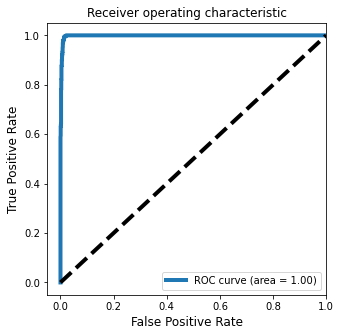

Weight,Feature
0.0172,medical
0.0140,selection
0.0134,computer science
0.0133,python
0.0110,clinical
0.0104,pharmaceutical
0.0104,scientific
0.0095,september
0.0090,business analyst
0.0087,science technology


In [204]:
model_evaluation(pl_e8)

# Experiment 8: Ensemble - Gradient Boosting Classifier

In [205]:
# Creating the pipeline
pl_e9 = make_pipeline(CountVectorizer(stop_words=custom_stop_words,
                                         ngram_range = (2,2),
                                         binary=True,
                                        min_df=5,
                                        max_df=0.25),
                         GradientBoostingClassifier(n_estimators=50,learning_rate=1.0,
                                                    max_depth=4))

Mean cross-val score: 0.9599818511796732
Standard deviation cross-val:0.01136078462581433
----------------------------------------
Classification Report
----------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1378
           1       0.95      1.00      0.97      1377

    accuracy                           0.97      2755
   macro avg       0.97      0.97      0.97      2755
weighted avg       0.97      0.97      0.97      2755

----------------------------------------
Confusion Matrix
----------------------------------------
                predicted_high_salary  predicted_low_salary
is_high_salary                   1377                     0
is_low_salary                      76                  1302


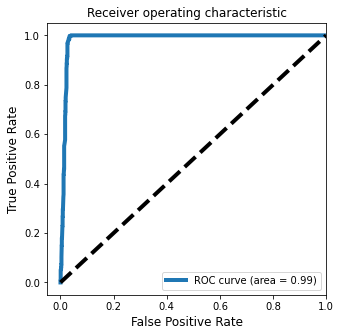

Weight,Feature
0.1322 ± 0.1719,computer science
0.0478 ± 0.0907,science related
0.0469 ± 0.0720,data science
0.0321 ± 0.0621,data engineer
0.0300 ± 0.0977,life sciences
0.0239 ± 0.0542,position description
0.0220 ± 0.0587,engineering science
0.0155 ± 0.0352,business analyst
0.0140 ± 0.0876,support workers
0.0139 ± 0.0650,data management


In [206]:
model_evaluation(pl_e9)